In [7]:
# ===============================
# Task 3: Correlation between News Sentiment and Stock Movement
# ===============================

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

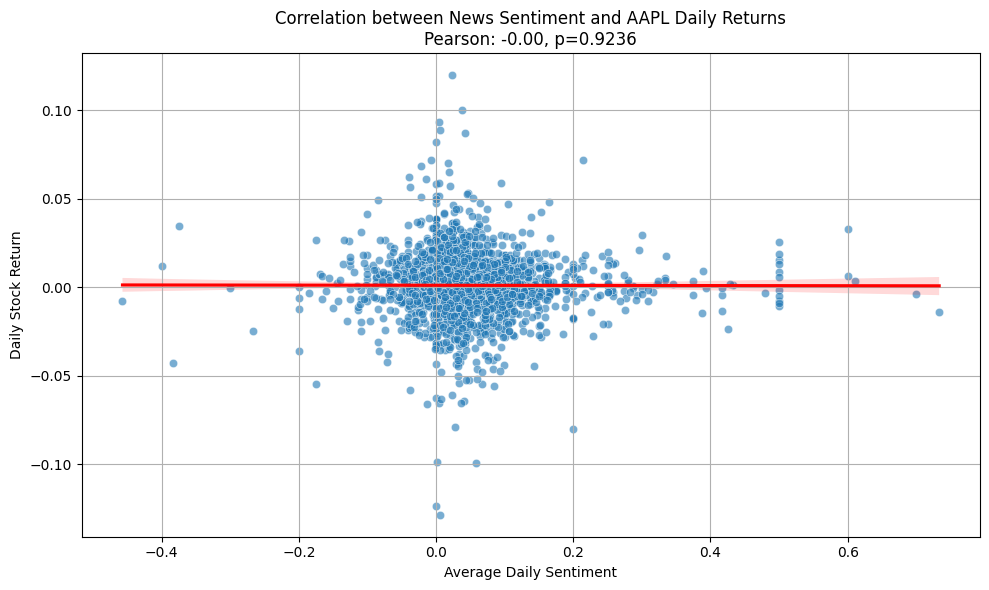

✅ Processed AAPL: Correlation = -0.0020, p = 0.9236


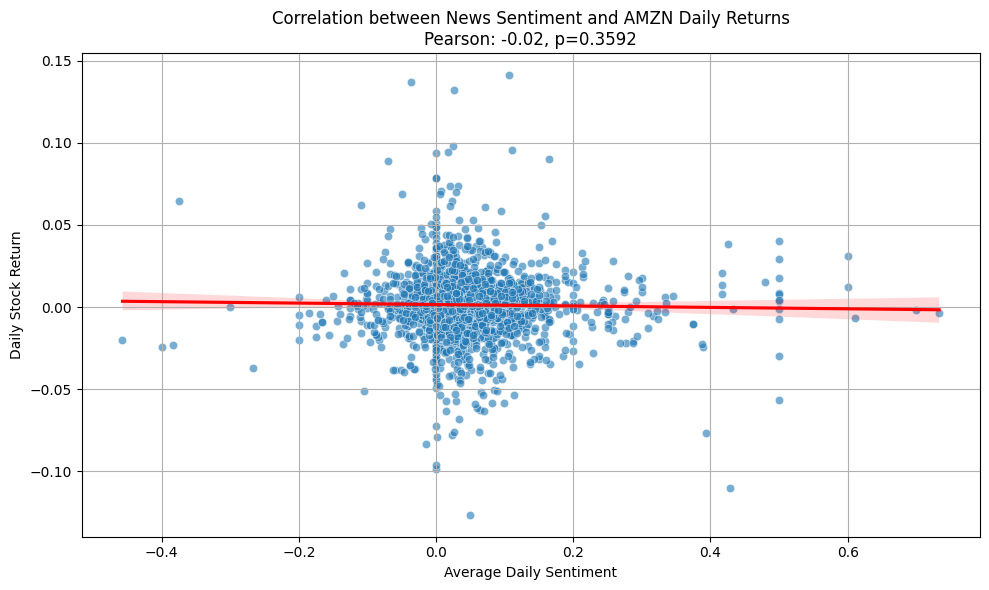

✅ Processed AMZN: Correlation = -0.0194, p = 0.3592


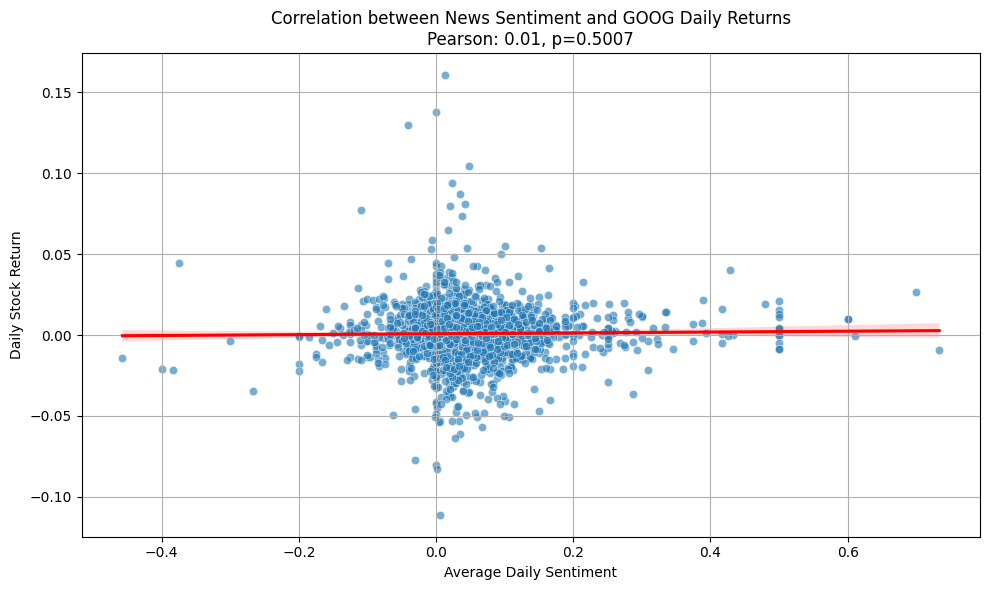

✅ Processed GOOG: Correlation = 0.0143, p = 0.5007


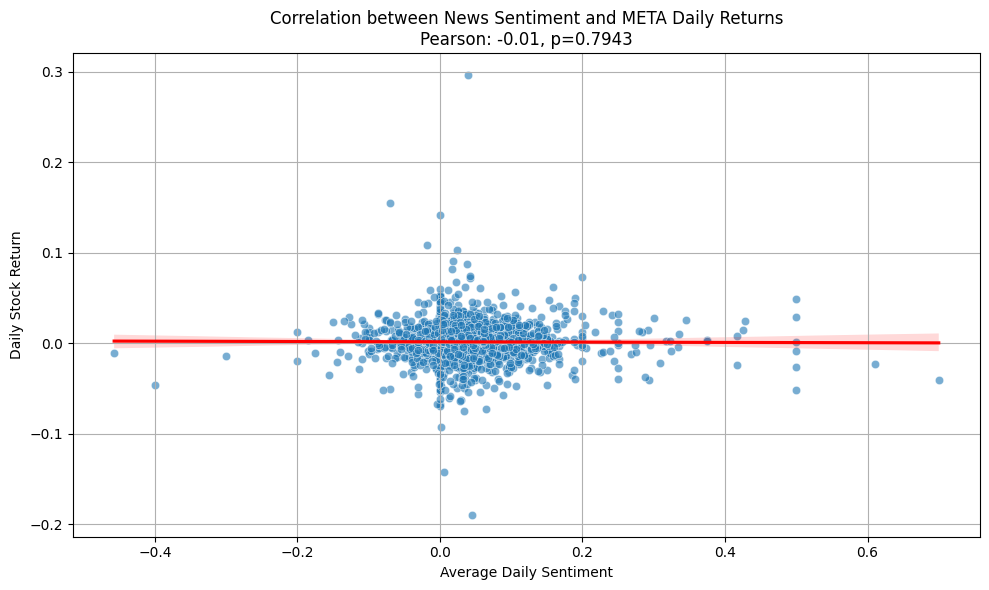

✅ Processed META: Correlation = -0.0061, p = 0.7943


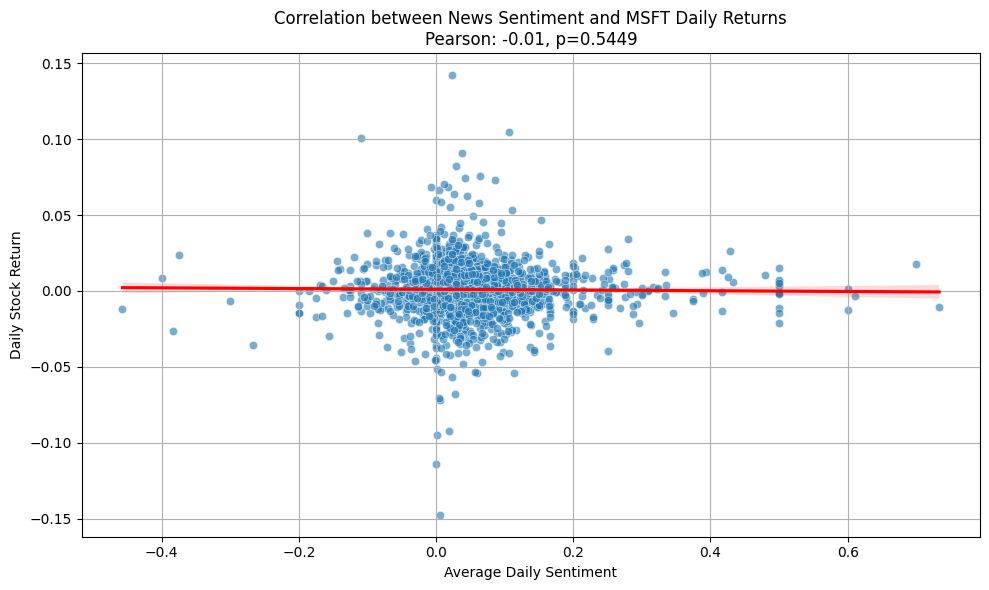

✅ Processed MSFT: Correlation = -0.0128, p = 0.5449


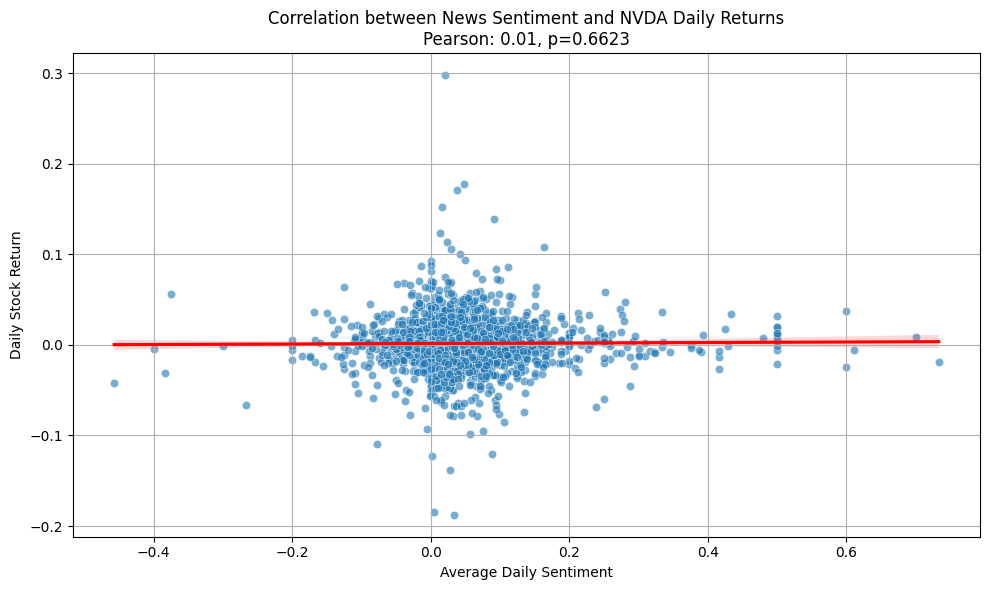

✅ Processed NVDA: Correlation = 0.0093, p = 0.6623


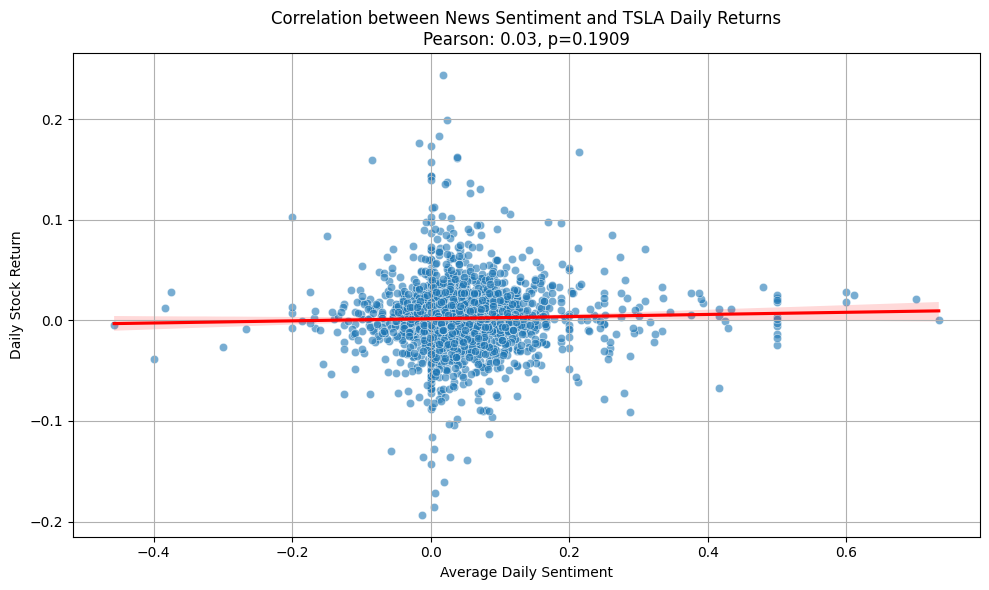

✅ Processed TSLA: Correlation = 0.0277, p = 0.1909

📊 Correlation Summary:
  Symbol  Correlation   p_value
6   TSLA     0.027734  0.190858
2   GOOG     0.014278  0.500748
5   NVDA     0.009262  0.662286
0   AAPL    -0.002033  0.923636
3   META    -0.006070  0.794338
4   MSFT    -0.012839  0.544877
1   AMZN    -0.019444  0.359160


In [22]:


# -------------------------------
# Load and Clean News Data
# -------------------------------
news_df = pd.read_csv('../Data/raw_analyst_ratings.csv')

# Convert 'date' to datetime and clean
news_df['date'] = pd.to_datetime(news_df['date'], errors='coerce')
news_df.dropna(subset=['date', 'headline'], inplace=True)
news_df.reset_index(drop=True, inplace=True)

# -------------------------------
# Perform Sentiment Analysis
# -------------------------------
def get_sentiment(text):
    """Returns sentiment polarity between -1 (negative) and +1 (positive)."""
    return TextBlob(text).sentiment.polarity

news_df['sentiment'] = news_df['headline'].apply(get_sentiment)

# -------------------------------
# Aggregate Sentiment Scores by Day
# -------------------------------
daily_sentiment = news_df.groupby(news_df['date'].dt.date)['sentiment'].mean().reset_index()
daily_sentiment.columns = ['date', 'average_sentiment']
daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date'])

# -------------------------------
# Process Each Stock File in Directory
# -------------------------------
stock_data_dir = "../Data/processed_stock_data"
plot_dir = "../Data/Outputs/Plots"
summary_output_dir = "../Data/Outputs"

# Ensure output directories exist
os.makedirs(plot_dir, exist_ok=True)
os.makedirs(summary_output_dir, exist_ok=True)

stock_files = [f for f in os.listdir(stock_data_dir) if f.endswith('.csv')]
results = []

for file in stock_files:
    symbol = file.replace('_processed.csv', '')
    stock_file_path = os.path.join(stock_data_dir, file)

    try:
        # Load stock data
        stock_df = pd.read_csv(stock_file_path)
        stock_df['Date'] = pd.to_datetime(stock_df['Date'])
        stock_df = stock_df[['Date', 'Close', 'Daily_Return']]

        # Merge with sentiment data
        merged_df = pd.merge(stock_df, daily_sentiment, left_on='Date', right_on='date', how='inner')
        merged_df.dropna(subset=['Daily_Return', 'average_sentiment'], inplace=True)

        # Skip if not enough data
        if len(merged_df) < 10:
            print(f"⚠️ Skipping {symbol}: not enough overlapping data.")
            continue

        # Correlation analysis
        correlation, p_value = pearsonr(merged_df['Daily_Return'], merged_df['average_sentiment'])
        results.append({'Symbol': symbol, 'Correlation': correlation, 'p_value': p_value})

        # Visualization
        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=merged_df, x='average_sentiment', y='Daily_Return', alpha=0.6)
        sns.regplot(data=merged_df, x='average_sentiment', y='Daily_Return', scatter=False, color='red')
        plt.title(f"Correlation between News Sentiment and {symbol} Daily Returns\nPearson: {correlation:.2f}, p={p_value:.4f}")
        plt.xlabel("Average Daily Sentiment")
        plt.ylabel("Daily Stock Return")
        plt.grid(True)
        plt.tight_layout()

        # Save plot
        plot_path = os.path.join(plot_dir, f"correlation_{symbol}.png")
        plt.savefig(plot_path)

        # Display plot
        plt.show()

        # Close the figure
        plt.close()

        print(f"✅ Processed {symbol}: Correlation = {correlation:.4f}, p = {p_value:.4f}")

    except Exception as e:
        print(f"❌ Error processing {symbol}: {e}")

# -------------------------------
# Output Summary
# -------------------------------
result_df = pd.DataFrame(results)
result_df.sort_values(by='Correlation', ascending=False, inplace=True)

print("\n📊 Correlation Summary:")
print(result_df)

# Save correlation summary
summary_path = os.path.join(summary_output_dir, "sentiment_correlation_summary.csv")
result_df.to_csv(summary_path, index=False)
